In [1]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights, vgg16
from PIL import Image

import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [13]:
# CIFAR10Dataset class
class CIFAR10Dataset(Dataset):
    def __init__(self, data_path, batch_files, transform=None, augmentation=None):
        self.data_path = data_path
        self.batch_files = batch_files
        self.augmentation = augmentation  # Augmentation for specific labels
        self.transform = transform  # Default transform for all other labels
        self.batch_data = None
        self.batch_labels = None
        self.batch_index = -1
        self.index_map = []
        self._create_index_map()

    def _create_index_map(self):
        """Create a map of global indices to batch indices."""
        for batch_num, batch_file in enumerate(self.batch_files):
            with open(os.path.join(self.data_path, batch_file), 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                batch_size = len(batch[b'labels'])
                self.index_map.extend([(batch_num, i) for i in range(batch_size)])

    def _load_batch(self, batch_num):
        """Load a batch given its batch number."""
        batch_file = self.batch_files[batch_num]
        with open(os.path.join(self.data_path, batch_file), 'rb') as f:
            batch = pickle.load(f, encoding='bytes')
            self.batch_data = batch[b'data'].reshape(-1, 3, 32, 32)
            self.batch_labels = batch[b'labels']
        self.batch_index = batch_num

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        batch_num, in_batch_idx = self.index_map[idx]

        # Load the batch if it's not already loaded
        if batch_num != self.batch_index:
            self._load_batch(batch_num)

        # Fetch image and label from the loaded batch
        image = self.batch_data[in_batch_idx]
        label = self.batch_labels[in_batch_idx]

        # Convert to HWC format (Height, Width, Channels)
        image = image.transpose(1, 2, 0)

        # Convert the image to a PIL image before applying transforms
        image = Image.fromarray(image)

        # Apply specific transformations for labels 2, 3, 5, and 7
        if label in [0, 3, 4, 5] and self.transform:
            image = self.transform(image)
        elif self.transform:
            image = self.transform(image)

        # At this point, all images should be resized to (224, 224)
        return image, label

In [9]:
import pickle  # Import pickle to save the model

def train_and_evaluate(trainloader, validloader, model, criterion, optimizer, num_epochs=10, patience=5, data_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # To store loss and accuracy for each epoch
    train_losses, valid_losses = [], []
    valid_accuracies = []  # To store validation accuracy
    best_valid_acc = 0.0  # Track best validation accuracy
    best_valid_loss = float('inf')  # Track best validation loss for early stopping
    epochs_no_improve = 0  # Counter for early stopping

    # Construct model save path based on data_path
    if data_path:
        model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model_with_aug.pkl"
    else:
        model_save_path = "resnet_model_with_aug.pkl"  # Fallback save path if data_path isn't provided

    # Training loop
    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}")  # Debugging line
        model.train()
        running_loss = 0.0
        total_train_samples = 0

        # Train on training data
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            total_train_samples += labels.size(0)

        # Compute epoch training loss
        epoch_train_loss = running_loss / total_train_samples
        train_losses.append(epoch_train_loss)
        print(f'Training: Loss: {epoch_train_loss:.4f}')

        # Validation loop
        model.eval()
        running_valid_loss = 0.0
        correct_predictions = 0
        total_valid_samples = 0

        with torch.no_grad():
            progress_bar = tqdm(validloader, desc=f'Epoch {epoch+1}/{num_epochs} (Valid)')
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_valid_loss += loss.item() * inputs.size(0)

                # Get the predicted labels and calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_valid_samples += labels.size(0)

        # Compute epoch validation loss
        epoch_valid_loss = running_valid_loss / total_valid_samples
        valid_losses.append(epoch_valid_loss)
        print(f'Validation: Loss: {epoch_valid_loss:.4f}')

        # Compute validation accuracy
        epoch_valid_acc = correct_predictions / total_valid_samples * 100
        valid_accuracies.append(epoch_valid_acc)
        print(f'Validation: Accuracy: {epoch_valid_acc:.2f}%')

        # Check if the current model has the best validation accuracy so far
        if epoch_valid_acc > best_valid_acc:
            best_valid_acc = epoch_valid_acc
            print(f'Saving best model at epoch {epoch+1} with validation accuracy {best_valid_acc:.2f}%')

            # Save the model using pickle at the constructed path
            with open(model_save_path, 'wb') as f:
                pickle.dump(model, f)

        # Check for early stopping based on validation loss
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print("Returning values...")  # Debugging line
    # Return the training and validation losses and validation accuracies
    return train_losses, valid_losses, valid_accuracies


In [4]:
def run_training(augment=False, epochs=10):

    torch.manual_seed(42)

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Path to the dataset in Google Drive
    data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'

    # Training batch file names (excluding the test batch)
    train_batches = [f'data_batch_{i}' for i in range(1, 6)]

    # Transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Augmentation

    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((224, 224)),  # Resize nach den anderen Transformationen
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if augment:
    # Instantiate dataset with transformations (for training and validation)
      train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform, augmentation=augmentation)
    else:
    # Instantiate dataset without transformations (for training and validation)
      train_dataset = CIFAR10Dataset(data_path, train_batches, transform=transform)

    # Split the training dataset into train and validation subsets
    train_size = int(0.9 * len(train_dataset))  # Use 90% for training
    valid_size = len(train_dataset) - train_size  # Use 10% for validation
    train_subset, valid_subset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

    # DataLoader for training and validation
    trainloader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=4)
    validloader = DataLoader(valid_subset, batch_size=128, shuffle=False, num_workers=4)

    # Instantiate the model (using ResNet-50)
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

    # Train and validate the model
    train_losses, valid_losses, valid_accuracies = train_and_evaluate(
        trainloader, validloader, model, criterion, optimizer, num_epochs=epochs, patience=2, data_path=data_path
    )

    return model, train_losses, valid_losses, valid_accuracies

In [5]:
# lets train the model without augmentation
model, train_losses, valid_losses, valid_accuracies = run_training(augment=False, epochs=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting epoch 1


Epoch 1/10 (Train): 100%|██████████| 352/352 [11:43<00:00,  2.00s/it]


Training: Loss: 0.5083


Epoch 1/10 (Valid): 100%|██████████| 40/40 [01:09<00:00,  1.75s/it]


Validation: Loss: 0.3299
Validation: Accuracy: 88.52%
Saving best model at epoch 1 with validation accuracy 88.52%
Starting epoch 2


Epoch 2/10 (Train): 100%|██████████| 352/352 [10:20<00:00,  1.76s/it]


Training: Loss: 0.2234


Epoch 2/10 (Valid): 100%|██████████| 40/40 [01:09<00:00,  1.74s/it]


Validation: Loss: 0.3309
Validation: Accuracy: 89.20%
Saving best model at epoch 2 with validation accuracy 89.20%
Starting epoch 3


Epoch 3/10 (Train): 100%|██████████| 352/352 [10:18<00:00,  1.76s/it]


Training: Loss: 0.1510


Epoch 3/10 (Valid): 100%|██████████| 40/40 [01:08<00:00,  1.72s/it]


Validation: Loss: 0.3192
Validation: Accuracy: 89.88%
Saving best model at epoch 3 with validation accuracy 89.88%
Starting epoch 4


Epoch 4/10 (Train): 100%|██████████| 352/352 [10:15<00:00,  1.75s/it]


Training: Loss: 0.1167


Epoch 4/10 (Valid): 100%|██████████| 40/40 [01:08<00:00,  1.72s/it]


Validation: Loss: 0.2596
Validation: Accuracy: 91.68%
Saving best model at epoch 4 with validation accuracy 91.68%
Starting epoch 5


Epoch 5/10 (Train): 100%|██████████| 352/352 [10:13<00:00,  1.74s/it]


Training: Loss: 0.0910


Epoch 5/10 (Valid): 100%|██████████| 40/40 [01:08<00:00,  1.72s/it]


Validation: Loss: 0.2849
Validation: Accuracy: 90.80%
Starting epoch 6


Epoch 6/10 (Train): 100%|██████████| 352/352 [10:16<00:00,  1.75s/it]


Training: Loss: 0.0817


Epoch 6/10 (Valid): 100%|██████████| 40/40 [01:08<00:00,  1.72s/it]

Validation: Loss: 0.2958
Validation: Accuracy: 90.54%
Early stopping at epoch 6
Returning values...


Now check the result first on the validation set.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from torch.utils.data import DataLoader

def test_model_with_confusion_matrix(model, testloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        progress_bar = tqdm(enumerate(testloader), total=len(testloader), desc='Testing')
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Append predictions and labels for confusion matrix and metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Identify misclassifications
            for j in range(labels.size(0)):
                if predicted[j] != labels[j]:
                    misclassified_images.append(inputs[j].cpu())
                    misclassified_labels.append(labels[j].cpu().numpy())
                    misclassified_preds.append(predicted[j].cpu().numpy())

    # Generate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print the computed metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix using seaborn with class names
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    return misclassified_images, misclassified_labels, misclassified_preds

Testing: 100%|██████████| 40/40 [01:09<00:00,  1.73s/it]


Confusion Matrix:
[[433   3  16   7   2   0   0   8  11   8]
 [  2 489   0   1   0   1   0   0   0  19]
 [  4   0 499  15   0   7   3   2   2   0]
 [  1   0   9 419   4  26   7   4   1   0]
 [  2   0  22  16 402   5   4  19   0   1]
 [  0   0  12  54   3 431   4  10   0   0]
 [  0   0  10  23   0   2 471   1   0   0]
 [  0   0   2   6   0   8   0 484   0   0]
 [  4   3   4   2   1   1   6   2 474   7]
 [  1   9   0   2   0   1   0   3   3 482]]
Accuracy: 0.9168
Precision: 0.9207
Recall: 0.9168
F1 Score: 0.9174


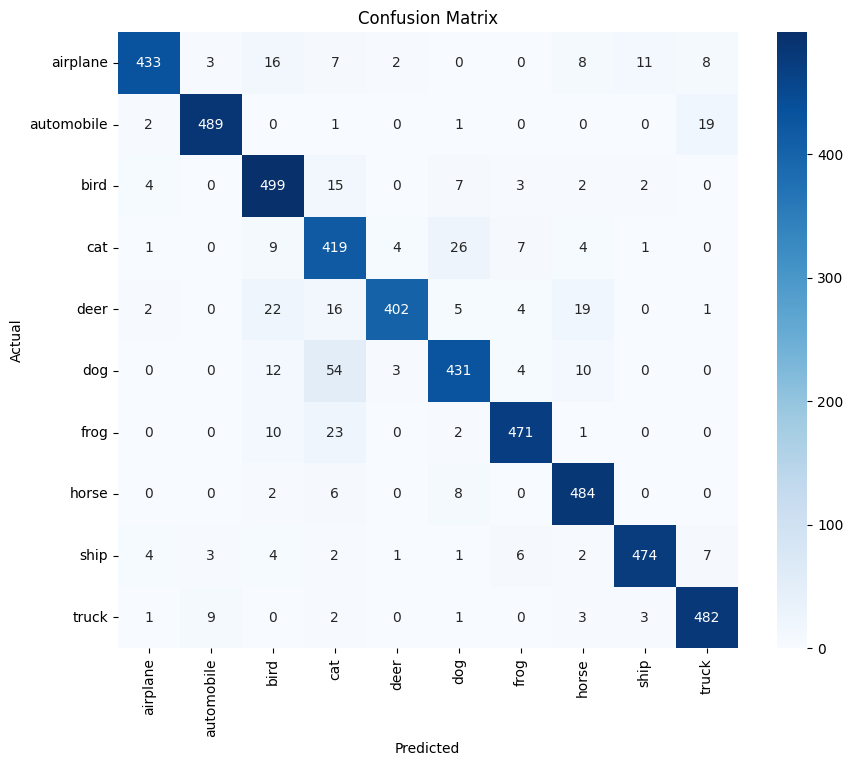

In [15]:
# Define class names based on the extracted labels
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

# Test the model and display confusion matrix and metrics
testloader = DataLoader(valid_subset, batch_size=128, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load our trained model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model_no_aug.pkl"
with open(model_save_path, 'rb') as f:
    model = pickle.load(f)

model.to(device)
misclassified_images, misclassified_labels, misclassified_preds = test_model_with_confusion_matrix(model, testloader)

For the classes 0, 3, 4, 5 the model performed poorly. These classes will be augmented.

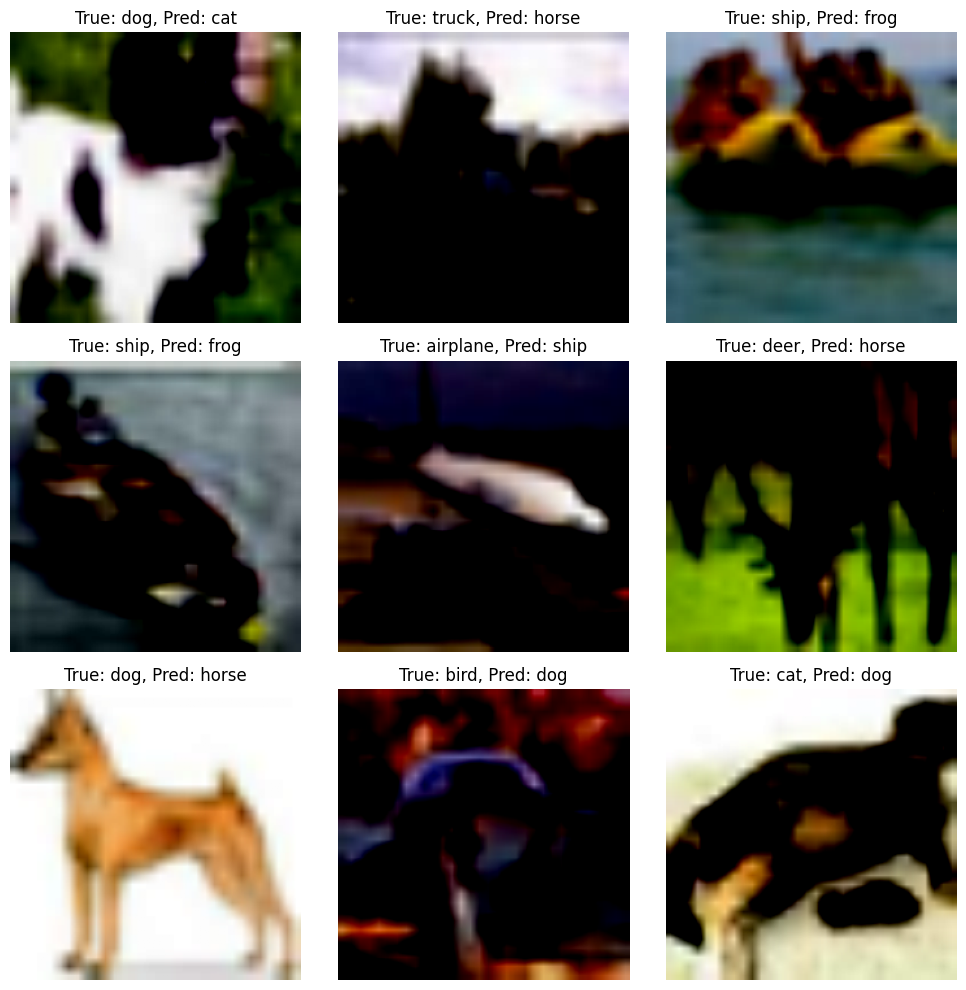

In [16]:
def display_misclassified_images(images, true_labels, predicted_labels, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"True: {class_names[true_labels[i]]}, Pred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display misclassified images
display_misclassified_images(misclassified_images, misclassified_labels, misclassified_preds)

Now evaluate the model on the test set

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Testing: 100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


Confusion Matrix:
[[907   5  27  16   2   2   4   7  17  13]
 [  2 960   0   0   0   0   0   1   2  35]
 [  7   0 919  33   7  18   9   3   2   2]
 [  4   1  17 900   8  45  10  13   2   0]
 [  2   0  43  32 865  10   8  40   0   0]
 [  0   0  20 111   2 842   3  22   0   0]
 [  1   1  25  46   1   6 915   5   0   0]
 [  2   1   4  19   1  14   0 958   1   0]
 [ 20   9  11   5   0   1   9   1 924  20]
 [  2  28   2   6   0   1   1   6   4 950]]
Accuracy: 0.9140
Precision: 0.9180
Recall: 0.9140
F1 Score: 0.9147


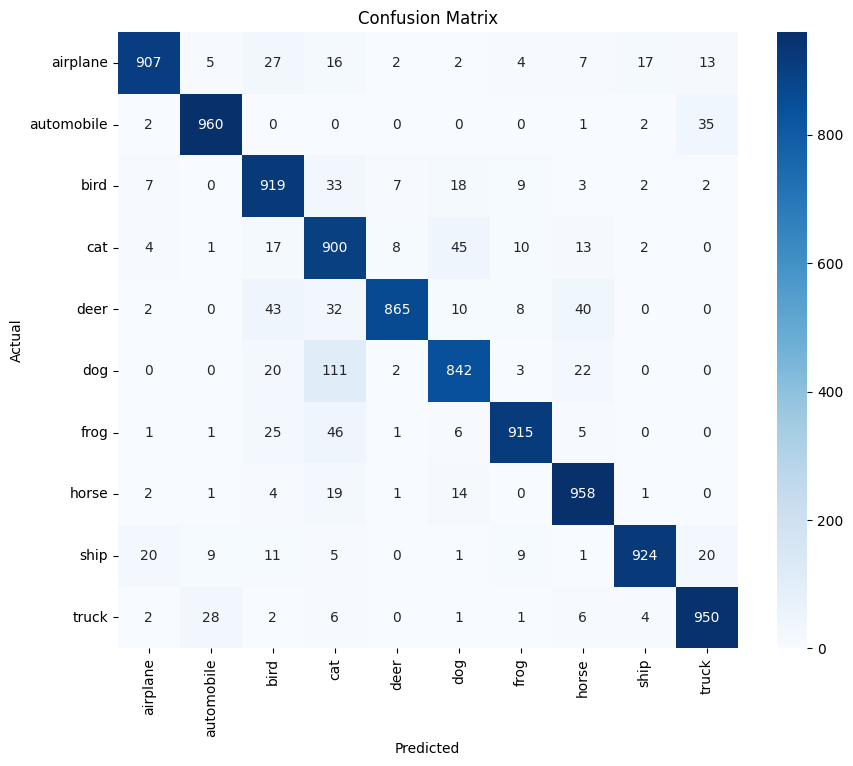

In [12]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
data_path = '/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/cifar-10-python/cifar-10-batches-py/'
test_batches = ['test_batch']

# Default transform for other labels (ensure resizing is included)
transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Define class names based on the extracted labels
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

# Instantiate the test dataset
test_dataset = CIFAR10Dataset(data_path, test_batches, transform=transform)

# Test the model and display confusion matrix and metrics
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load our trained model
model_save_path = '/'.join(data_path.split('/')[:-3]) + "/resnet_model_no_aug.pkl"
with open(model_save_path, 'rb') as f:
    model = pickle.load(f)

model.to(device)

misclassified_images, misclassified_labels, misclassified_preds = test_model_with_confusion_matrix(model, testloader)

Now with augmentation on poorly classified labels!


In [10]:
# lets train the model without augmentation
model, train_losses, valid_losses, valid_accuracies = run_training(augment=True, epochs=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting epoch 1


Epoch 1/10 (Train):  59%|█████▉    | 208/352 [06:09<04:15,  1.78s/it]


KeyboardInterrupt: 